In [15]:
import os
import sys
currentdir = os.getcwd() 
parent_dir = os.path.dirname(currentdir)
sys.path.insert(0, parent_dir) 
import pandas as pd
import numpy as np
import ast
import json

from df_utils import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pickle
#sys.path.insert(0,'../utils')
from helper_solution_analysis import *
from run_strategies import *

sns.set(font_scale=2, style = 'ticks', palette = 'deep') 
from matplotlib.colors import ListedColormap

import gym
import gym_furniture

In [16]:
# get data csv
par_parent_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
data_file = 'data/online/full_experiment/data_furnituremanufacturing_2021-08-11_09-15.csv'
data_path = os.path.join(par_parent_dir, data_file)

# transform to dataframe
df, df_model, df_ge, df_vp_sol, df_qual,  df_actions, df_built, df_resources, df_play_times = decompose_csv(data_path)
df_complete_sol =  get_complete_sol(df_resources)
df_diff_with_mask = get_diff_mask(df_vp_sol, df_model, df_complete_sol)


read cache


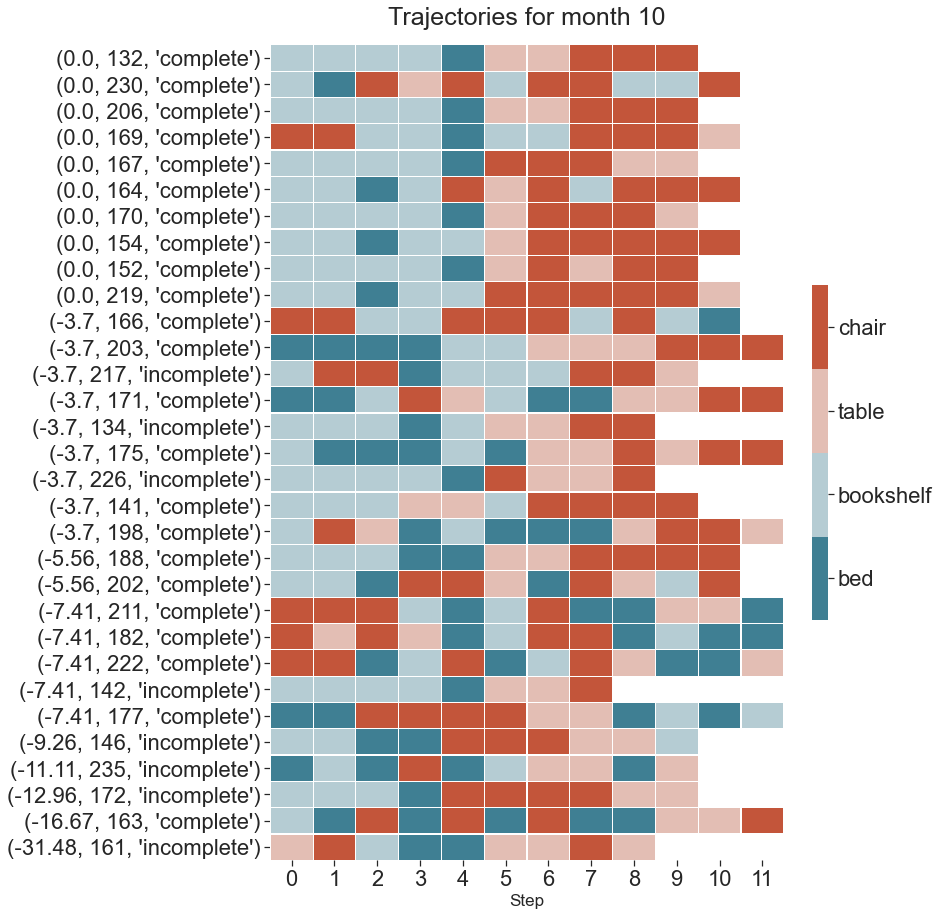

In [17]:



def plot_monthly_solution_traj(month, vps, parts = True, c_type = 'part'):
    fig = plt.figure(figsize=(10, 15))
    if parts:
        df_solutions = part_list(df_built,vps,month)
        colors = ["#7dcea0","#196f3d","#a9cce3",  "#1f618d","#edbb99",  "#af601a", "#d2b4de","#5b2c6f" ]
        colormap = ListedColormap(sns.color_palette(colors).as_hex())

    else:
        df_solutions = furniture_list(df_built,vps,month)
        if c_type == 'profit':
            df_solutions = map_to_profit(df_solutions, month-1)
        colormap = sns.diverging_palette(220, 20, n=4)

    steps = df_solutions.columns
    df_diff_with_mask = get_diff_mask(df_vp_sol, df_model, df_complete_sol)
    df_solutions['complete'] = df_diff_with_mask[df_diff_with_mask.month == month].complete

    df_solutions['difference'] = df_diff_with_mask[df_diff_with_mask.month == month].difference
    df_solutions['difference'] = df_solutions['difference'].apply(lambda x: round(x,2))
    #df_solutions = df_solutions.sort_values(by=list(df_solutions.columns))
    df_solutions = df_solutions.sort_values(by='difference', ascending = False)
    y_axis_labels = list(zip(list(df_solutions.difference), list(df_solutions.index), list(df_solutions.complete)))
    g= sns.heatmap(data = df_solutions[steps] , 
                            cmap = colormap,
                            yticklabels=y_axis_labels,  cbar_kws = dict(use_gridspec=False,location="right", 
                                                                        fraction = 0.03),
                            annot = False, linewidths=0.2)
    g.set_facecolor('xkcd:white')
    colorbar = g.collections[0].colorbar
    #colorbar = fig.colorbar(g)
    r = colorbar.vmax - colorbar.vmin
    if c_type != 'profit':
        r = colorbar.vmax - colorbar.vmin
        if parts:
            colorbar.set_ticks([colorbar.vmin + 0.5 * r / (8) + r * i / (8) for i in range(8)])
            colorbar.set_ticklabels(['bed frame', 'bed top', 'shelf frame','shelf',  'table leg', 'table top', 'chair leg', 'chair back'])
        else:
            colorbar.set_ticks([colorbar.vmin + 0.5 * r / (4) + r * i / (4) for i in range(4)])
            colorbar.set_ticklabels(['bed', 'bookshelf',  'table', 'chair'])        
    plt.title('Trajectories for month ' + str(month), fontsize = 25, pad = 20)
    xlabel = plt.xlabel('Step', fontsize = 17)
    if parts:
        filename = 'part_trajectories_month_' +str(month)+'.jpg'
    else:
        filename = 'full_furniture_trajectories_month_' +str(month)+'.jpg'
    if c_type == 'profit':
        fig.savefig('Images/solution_trajectories/colored_by_profit/'+filename,bbox_inches='tight')

    else:
        fig.savefig('Images/solution_trajectories/colored_by_items/'+filename,bbox_inches='tight')

vps = df_resources['vp'].unique()   

#for m in range(1,13):
    #plot_monthly_solution_traj(m,vps)
#    plt.close()
plot_monthly_solution_traj(10,vps, parts = False, c_type='part')


In [18]:


def plot_vp_traj(vp, c_type = 'profit'):
    fig = plt.figure(figsize=(10, 12))

    #vps = [132]
    colormap = sns.diverging_palette(220, 20, n=4)
    if c_type == 'profit':
        df_solutions = map_to_profit(furniture_list_one_vp(df_built,vp), target = 'vp')
        b_label = 'monthly min-max norm profit'
    else:
        df_solutions = furniture_list_one_vp(df_built,vp)
        b_label = 'item'
    steps = df_solutions.columns
    df_solutions['complete'] = list(df_diff_with_mask[df_diff_with_mask.index == vp].complete)

    df_solutions['difference'] = list(df_diff_with_mask[df_diff_with_mask.index == vp].difference)
    y_axis_labels = list(zip(list(df_solutions.difference.astype(int)), list(df_solutions.index), list(df_solutions.complete)))
    g= sns.heatmap(data = df_solutions[steps] , 
                            cmap = colormap,
                           cbar_kws = dict(use_gridspec=False,location="right",  fraction = 0.03, label= b_label),yticklabels=y_axis_labels,
                            annot = False, linewidths=0.2)
    g.set_facecolor('xkcd:white')
    
    colorbar = g.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin
    if c_type != 'profit':
            colorbar.set_ticks([colorbar.vmin + 0.5 * r / (4) + r * i / (4) for i in range(4)])
            colorbar.set_ticklabels(['bed', 'bookshelf',  'table', 'chair'])  
    plt.title('Trajectories from vp ' + str(vp), fontsize = 25, pad = 20)
    xlabel = plt.xlabel('Step', fontsize = 17)
    if c_type == 'profit':
        fig.savefig('Images/solution_trajectories/colored_by_profit/vps/trajectories_vp_' +str(vp)+'.jpg',bbox_inches='tight')
    else:
        fig.savefig('Images/solution_trajectories/colored_by_items/vps/trajectories_vp_' +str(vp)+'.jpg',bbox_inches='tight')

for vp in  df_resources['vp'].unique():
     plot_vp_traj(vp)
     plt.close()
     plot_vp_traj(vp, 'part')
     plt.close()


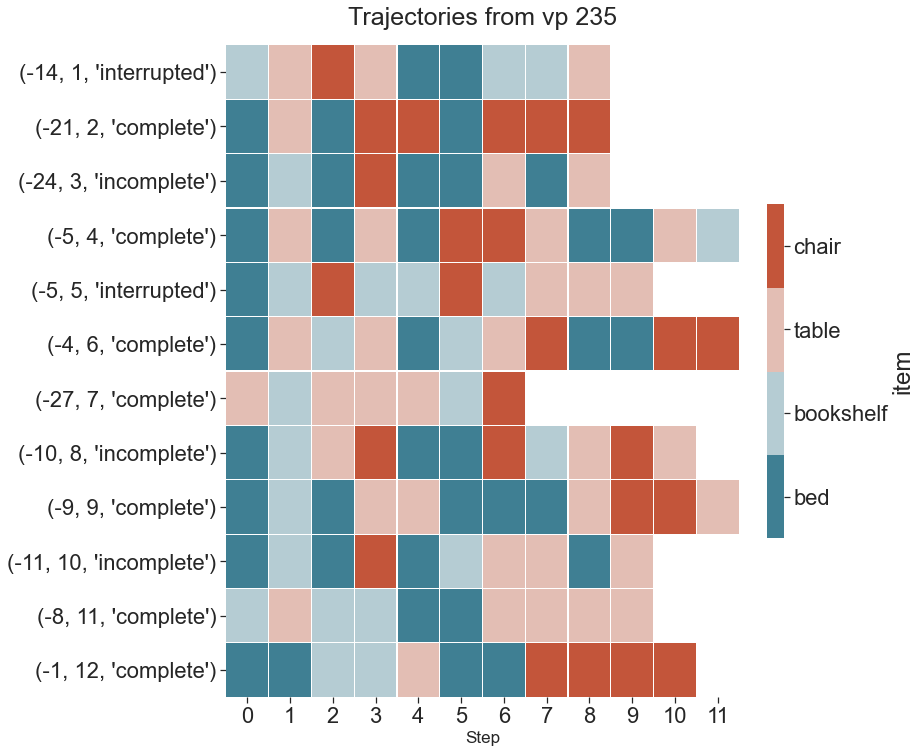

In [19]:
plot_vp_traj(vp, 'part')


# Cluster trajectories

In [20]:
def get_furn_items(traj):
    furniture = [0,0,0,0]
    solution = []
    solution.append(tuple(furniture))
    for a in traj:
        furniture[a] += 1
        solution.append(tuple(furniture))
   
    return solution

env= gym.make('SmallFurniture-v0')

global_greedy_rewards, global_greedy_actions, global_greedy_states = strategy_run(env)
grouped_greedy_rewards,grouped_greedy_actions, grouped_greedy_states  = strategy_run(env, strategy = 'grouped greedy', first_group = 1)
material_balancing_rewards, material_balancing_actions, material_balancing_states = strategy_run(env, strategy = 'material balancing')
greedy_material_balancing_rewards, greedy_material_balancing_actions, greedy_material_balancing_states = strategy_run(env, strategy = 'greedy material balancing')
greedy_then_material_balancing_rewards, greedy_then_material_balancing_actions, greedy_then_material_balancing_states = strategy_run(env,strategy = 'greedy, then material balancing')
minimize_min_rewards, minimize_min_actions, minimize_min_states = strategy_run(env,strategy = 'minimize_min')
gr_minimize_min_rewards, gr_minimize_min_actions, gr_minimize_min_states = strategy_run(env,strategy = 'greedy_minimize_min')


strategy_dict = {'global greedy':global_greedy_actions,
                 'grouped greedy': grouped_greedy_actions,
                 'material balancing':material_balancing_actions,
                 'greedy material balancing':greedy_material_balancing_actions,
                 'greedy, then material balancing': greedy_then_material_balancing_actions,
                 'minimize_min':minimize_min_actions,
                 'greedy_minimize_min': gr_minimize_min_actions}


stratsol = {}
m = 0
for k,v in strategy_dict.items():
    stratsol[k] = {}
    for m in range(12):

        stratsol[k][m+1] = get_furn_items(v[m])[-1]
        

df_strat_paths = pd.DataFrame.from_dict(stratsol, orient = 'index')
df_strat_paths

,1,2,3,4,5,6,7,8,9,10,11,12
global greedy,"(1, 4, 3, 3)","(0, 3, 0, 0)","(0, 4, 3, 1)","(1, 4, 3, 2)","(1, 4, 5, 0)","(1, 4, 3, 3)","(6, 0, 0, 0)","(1, 4, 2, 3)","(1, 4, 3, 0)","(1, 4, 2, 3)","(1, 4, 5, 0)","(1, 4, 1, 1)"
grouped greedy,"(0, 4, 4, 1)","(1, 1, 2, 1)","(1, 3, 4, 0)","(0, 4, 4, 0)","(1, 4, 5, 0)","(0, 4, 4, 1)","(4, 0, 4, 0)","(1, 3, 4, 0)","(1, 3, 4, 2)","(1, 3, 4, 0)","(1, 4, 5, 0)","(0, 3, 3, 1)"
material balancing,"(5, 1, 3, 3)","(6, 0, 0, 3)","(2, 3, 3, 2)","(2, 3, 3, 3)","(1, 4, 5, 0)","(5, 1, 3, 3)","(0, 3, 5, 0)","(5, 1, 3, 3)","(4, 2, 3, 3)","(6, 0, 3, 3)","(1, 4, 3, 3)","(6, 0, 3, 3)"
greedy material balancing,"(5, 1, 3, 3)","(6, 0, 0, 3)","(2, 3, 3, 2)","(2, 3, 3, 3)","(1, 4, 5, 0)","(5, 1, 3, 3)","(0, 4, 2, 0)","(5, 1, 3, 3)","(4, 2, 3, 3)","(6, 0, 3, 3)","(1, 4, 3, 3)","(6, 0, 3, 3)"
"greedy, then material balancing","(1, 4, 1, 5)","(0, 3, 0, 0)","(1, 4, 2, 3)","(1, 4, 2, 4)","(1, 4, 5, 0)","(1, 4, 1, 5)","(6, 0, 0, 0)","(1, 4, 1, 5)","(1, 4, 2, 4)","(1, 4, 1, 5)","(1, 4, 3, 3)","(1, 4, 0, 5)"
minimize_min,"(0, 4, 4, 1)","(0, 3, 0, 0)","(0, 4, 3, 1)","(0, 4, 4, 0)","(1, 4, 0, 6)","(0, 4, 4, 1)","(1, 4, 0, 0)","(0, 4, 3, 1)","(1, 4, 3, 0)","(0, 4, 3, 1)","(1, 4, 0, 6)","(1, 4, 1, 1)"
greedy_minimize_min,"(0, 5, 0, 0)","(0, 3, 0, 0)","(0, 5, 0, 0)","(0, 5, 0, 0)","(0, 5, 0, 0)","(0, 5, 0, 0)","(0, 5, 0, 0)","(0, 5, 0, 0)","(0, 5, 0, 0)","(0, 5, 0, 0)","(0, 5, 0, 0)","(0, 5, 0, 0)"


/home/cath/Downloads/s/envs/plexplain/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


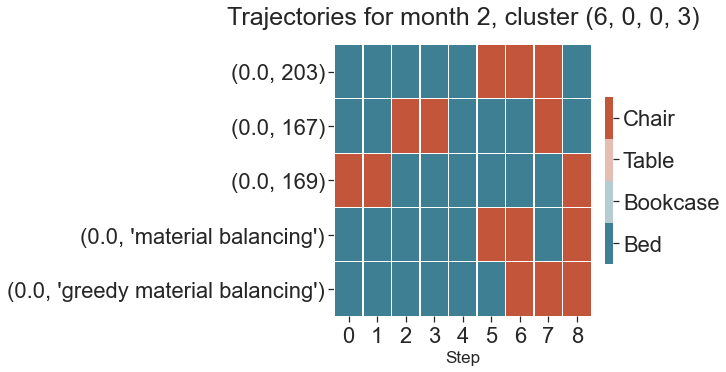

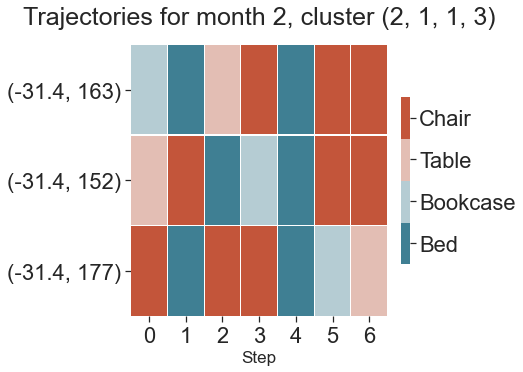

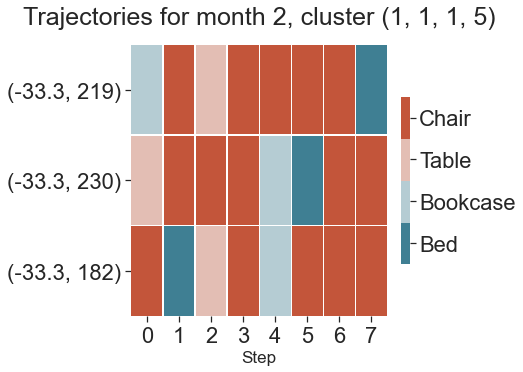

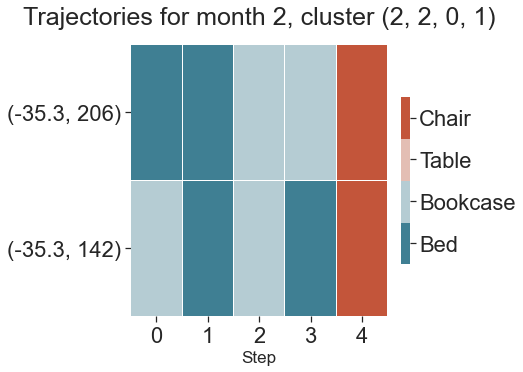

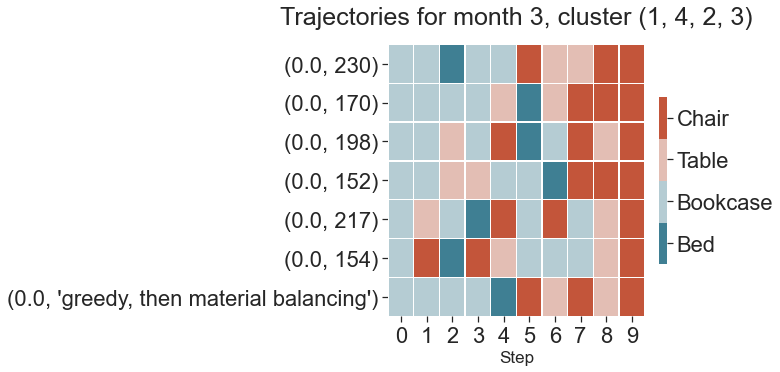

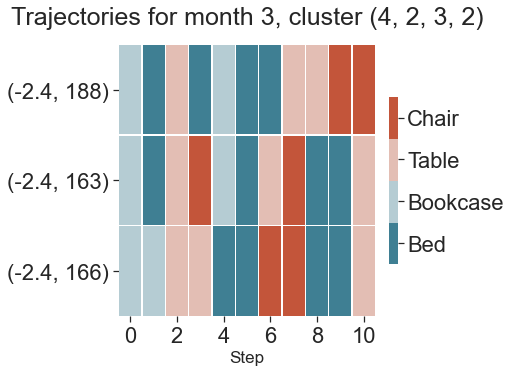

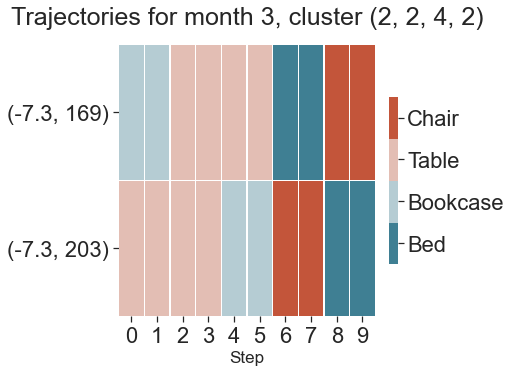

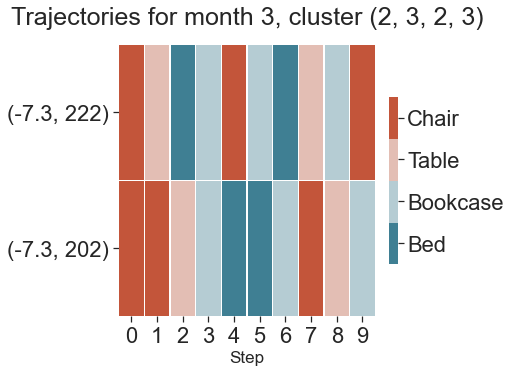

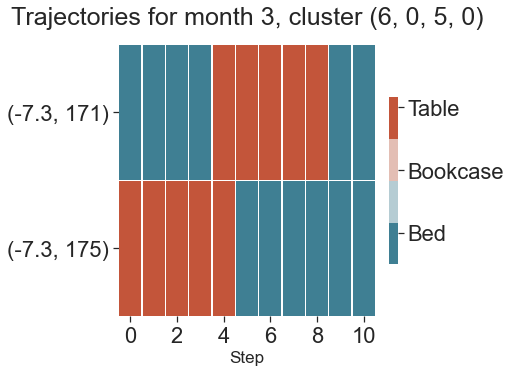

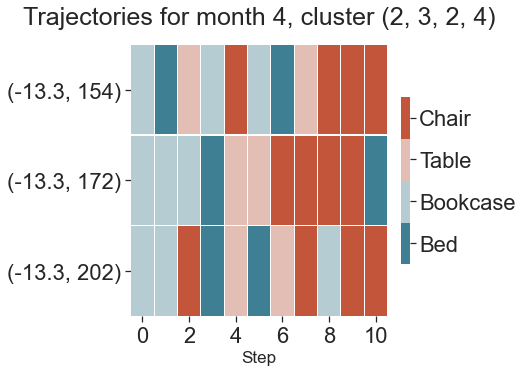

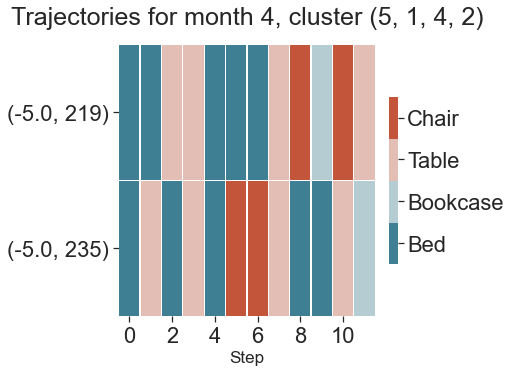

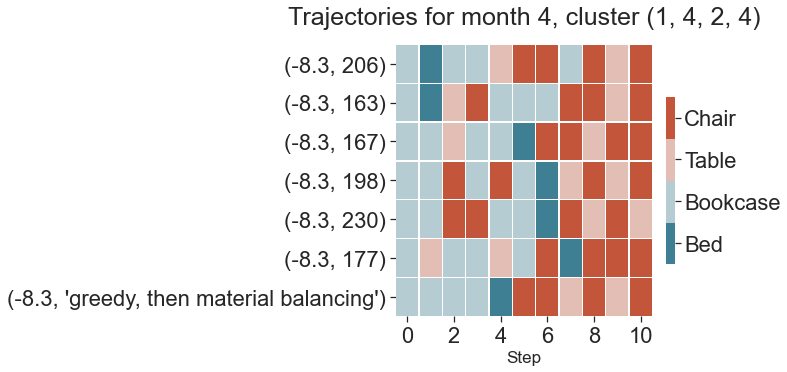

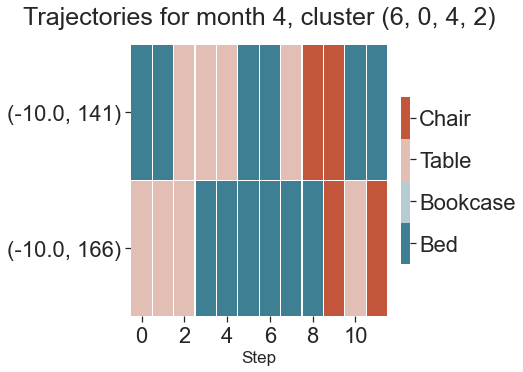

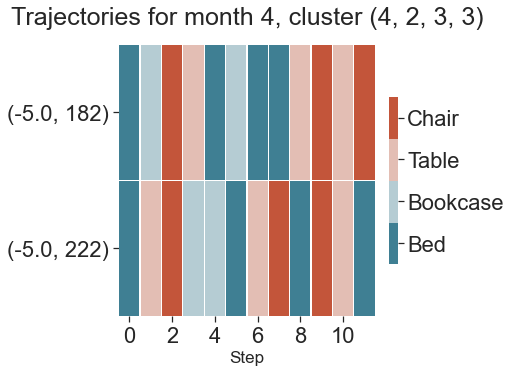

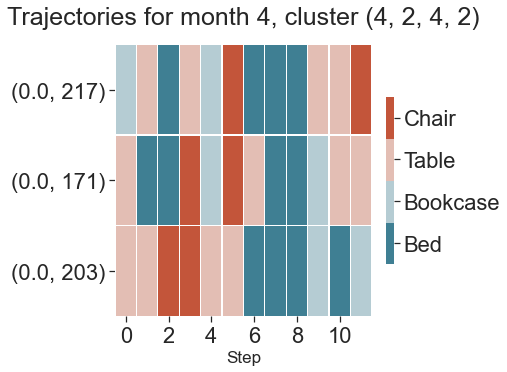

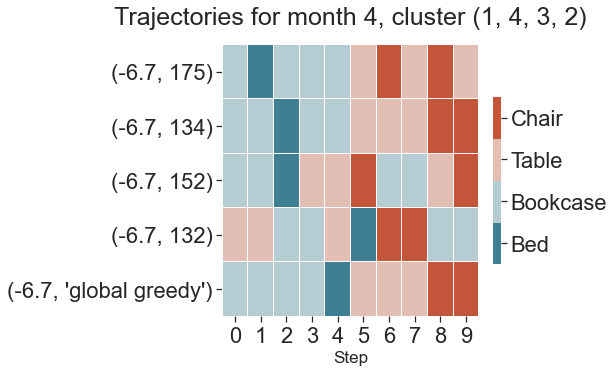

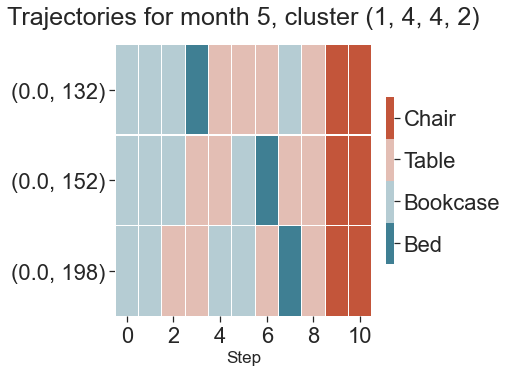

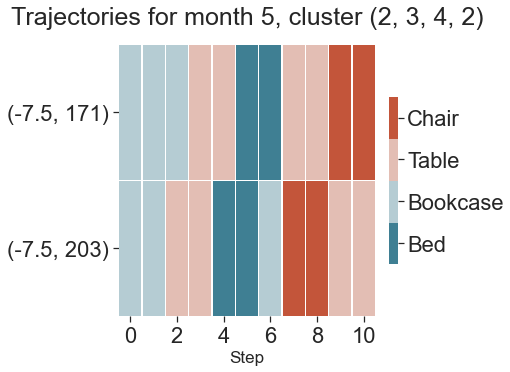

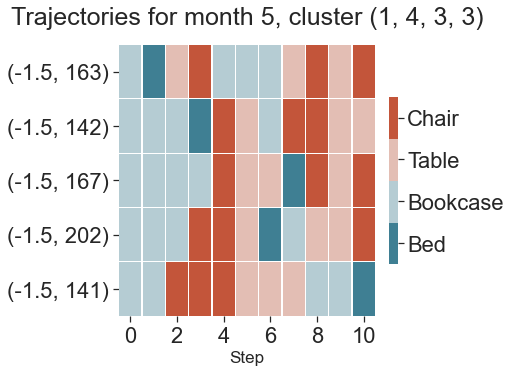

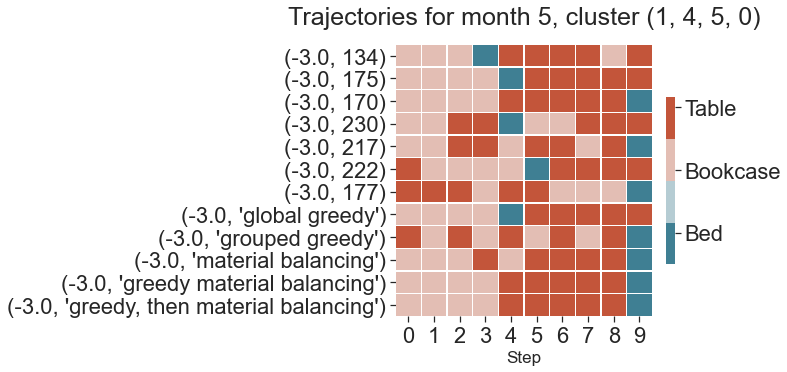

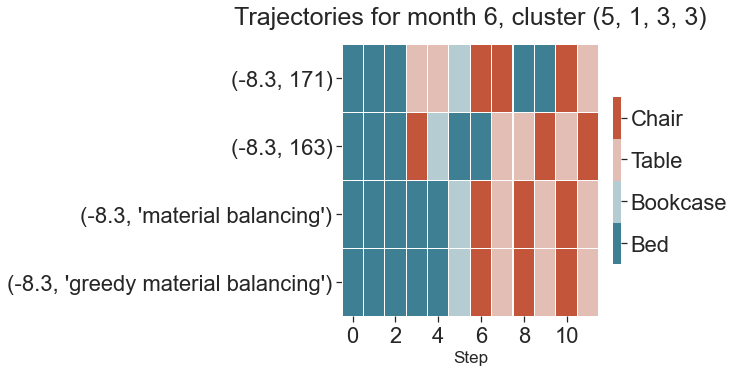

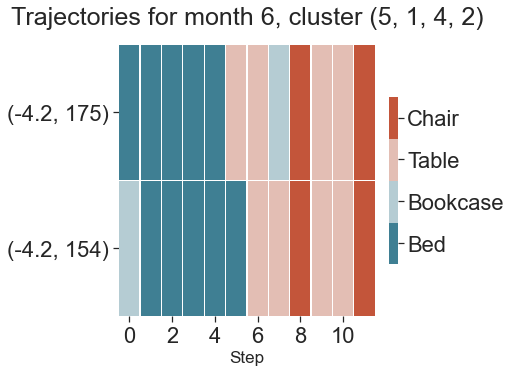

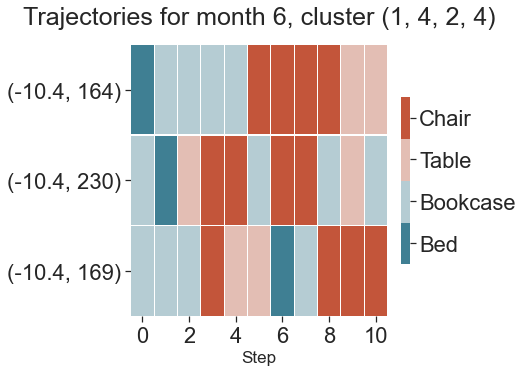

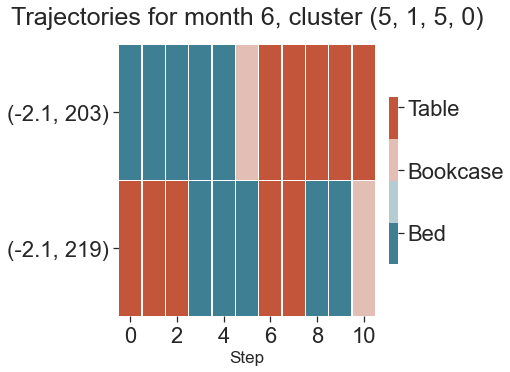

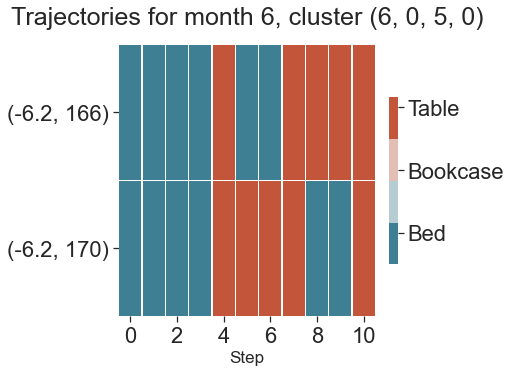

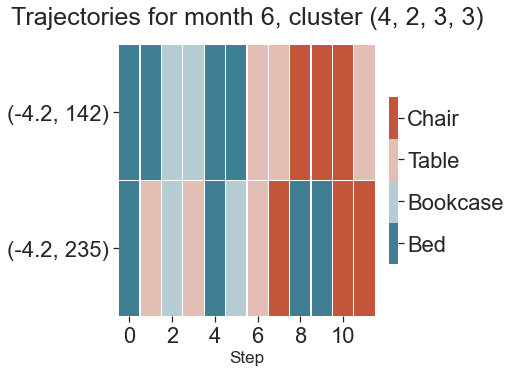

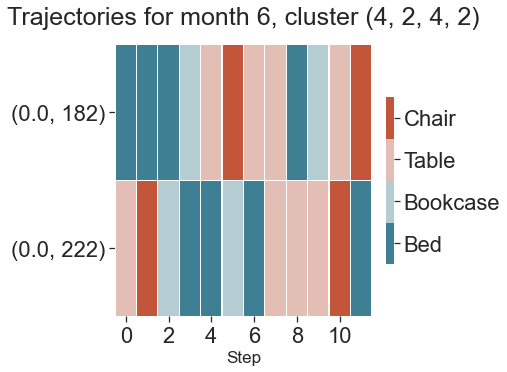

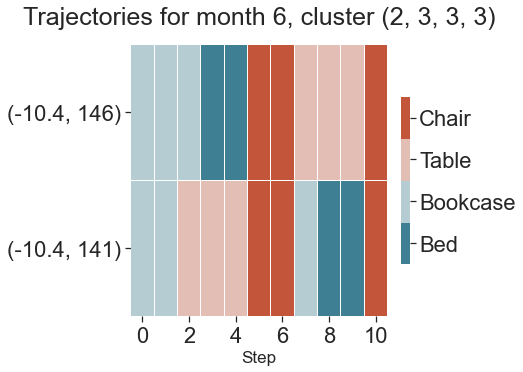

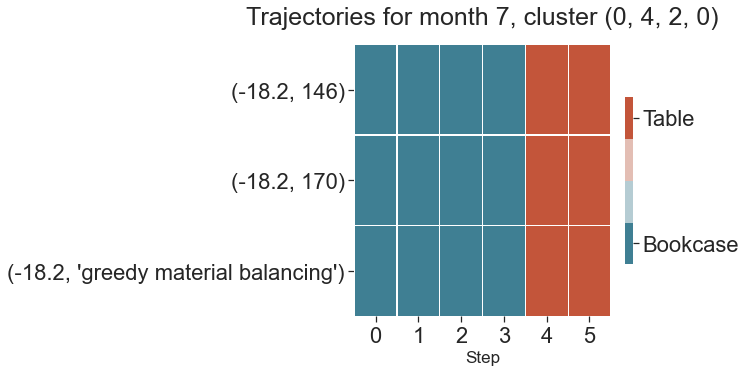

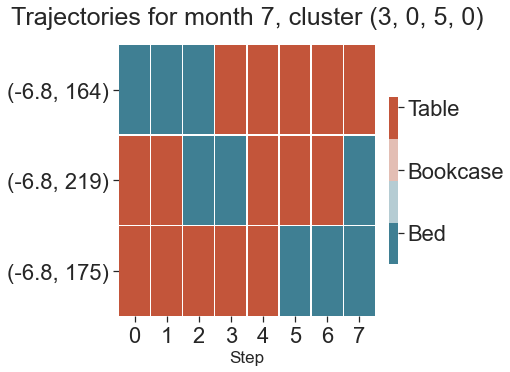

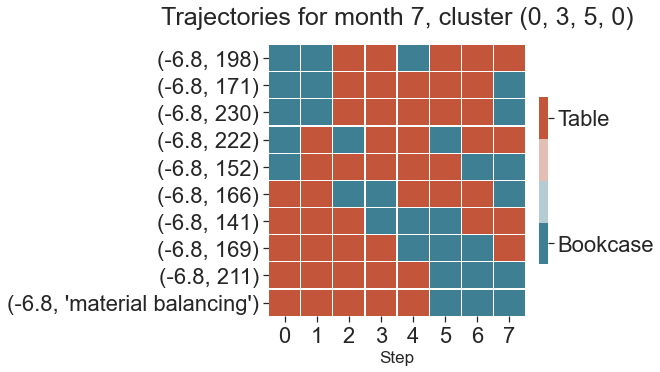

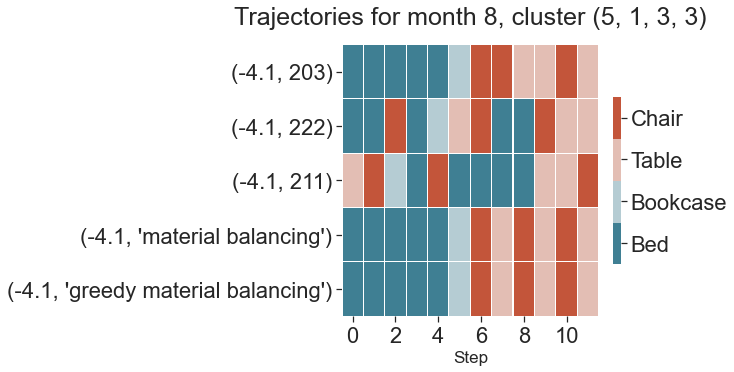

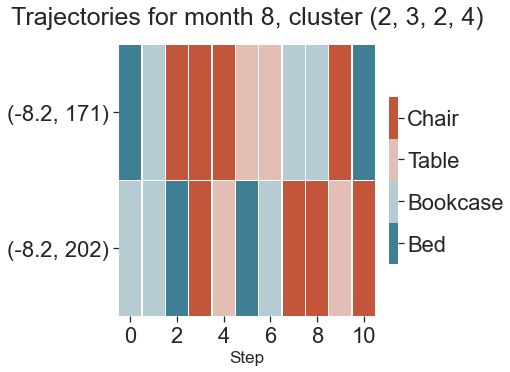

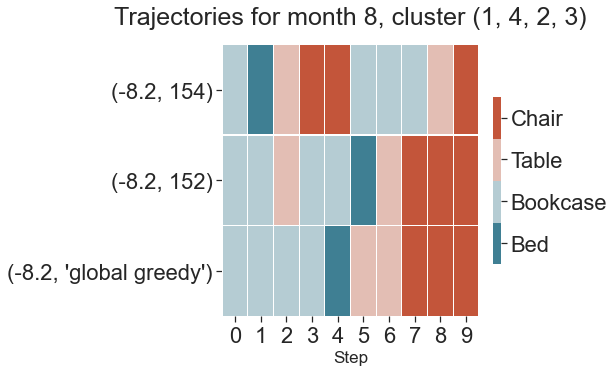

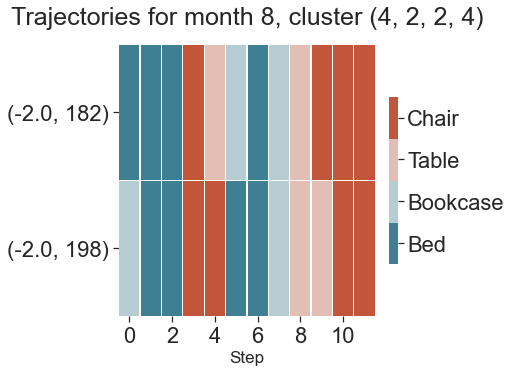

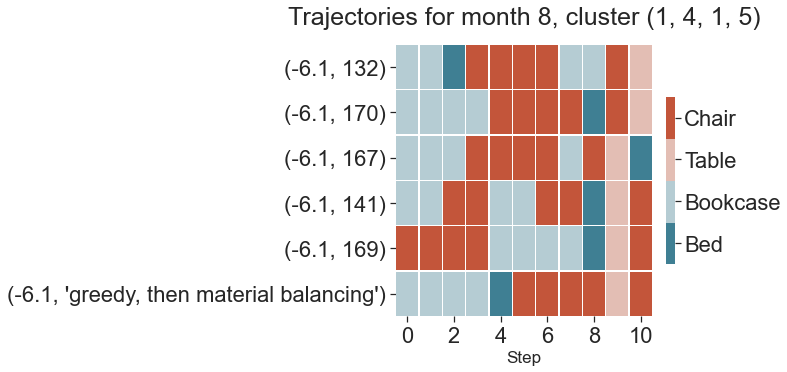

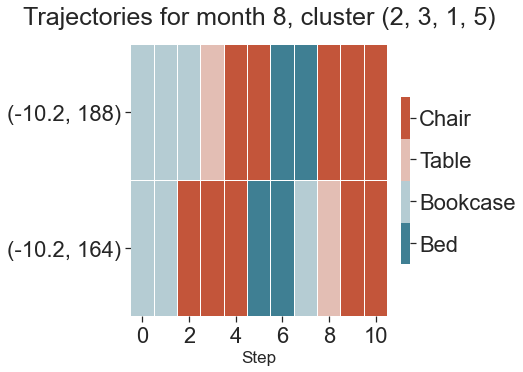

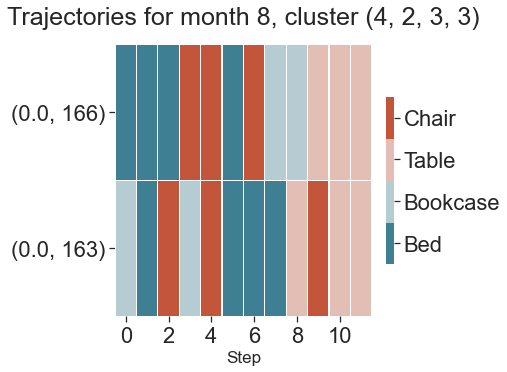

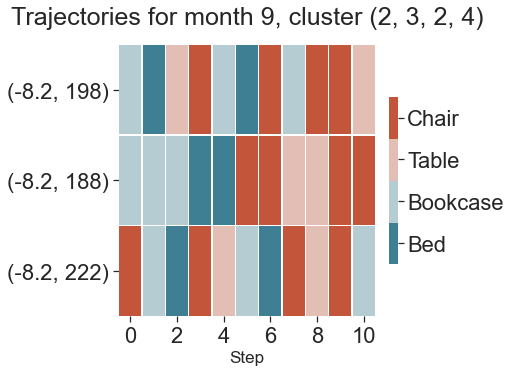

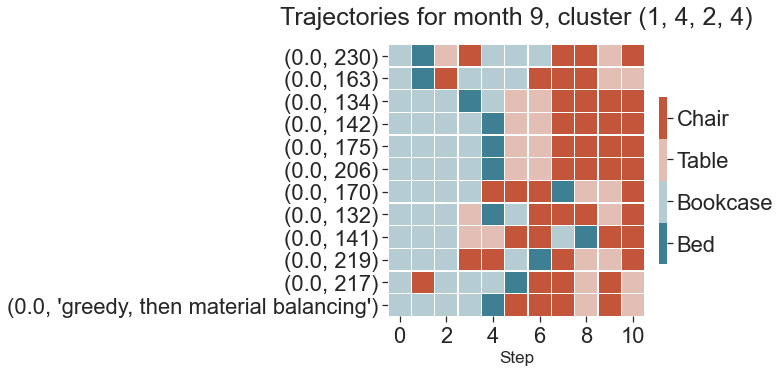

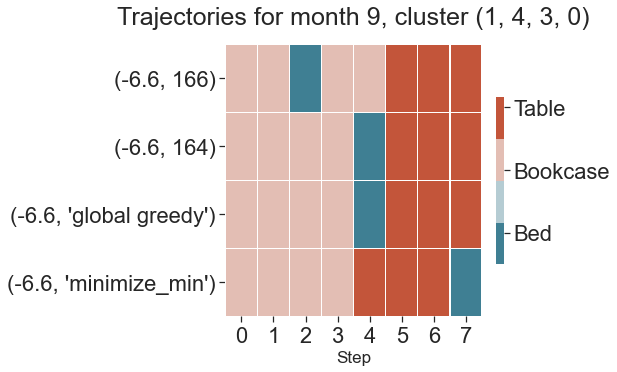

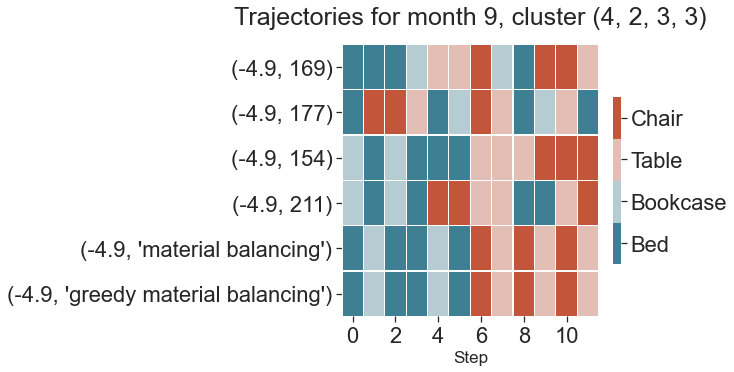

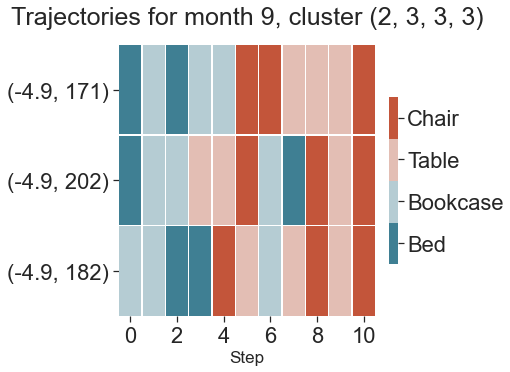

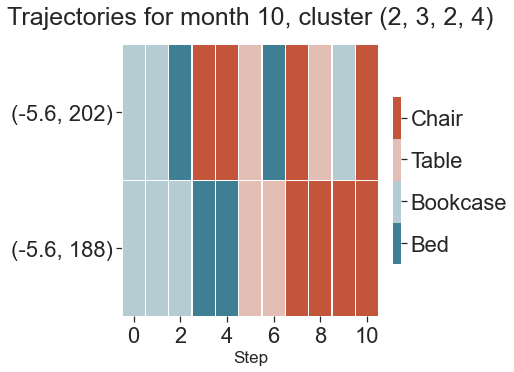

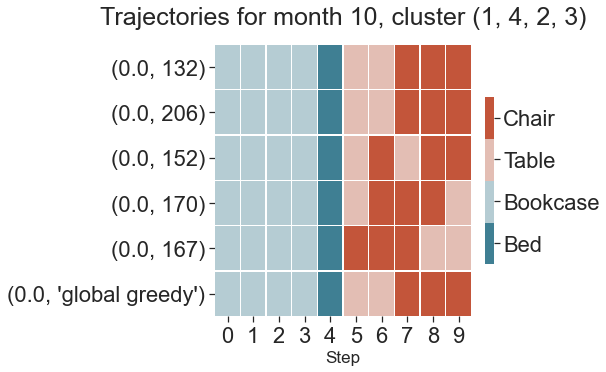

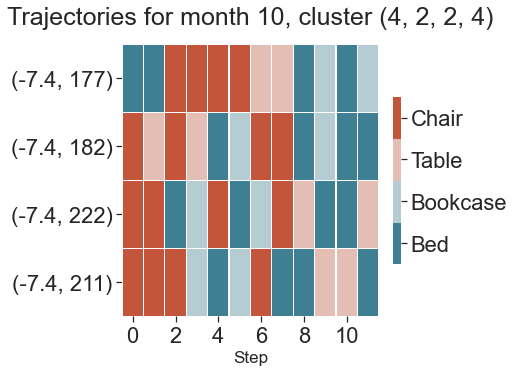

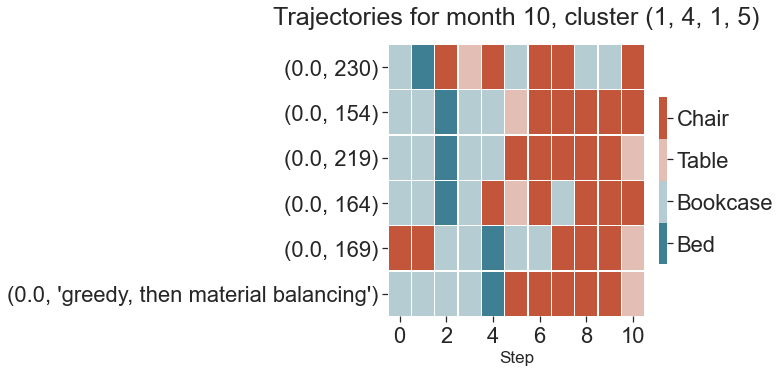

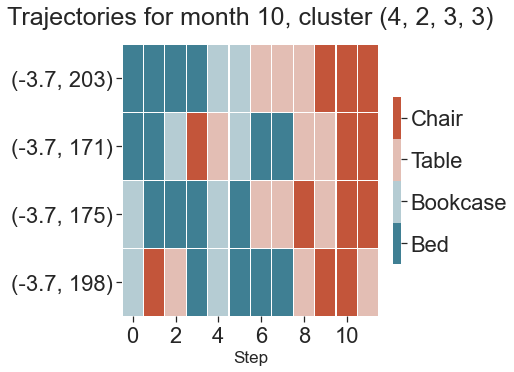

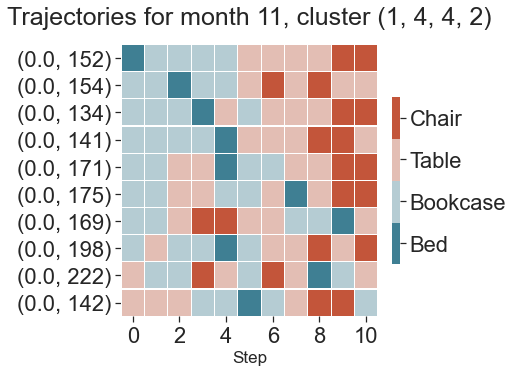

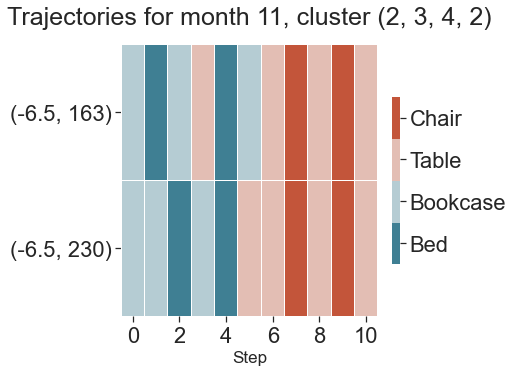

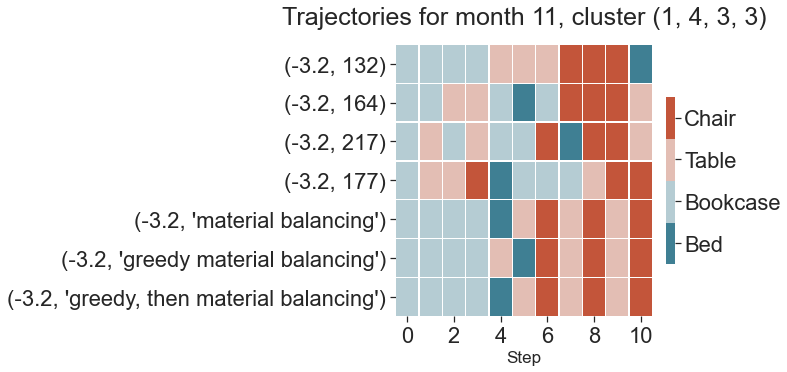

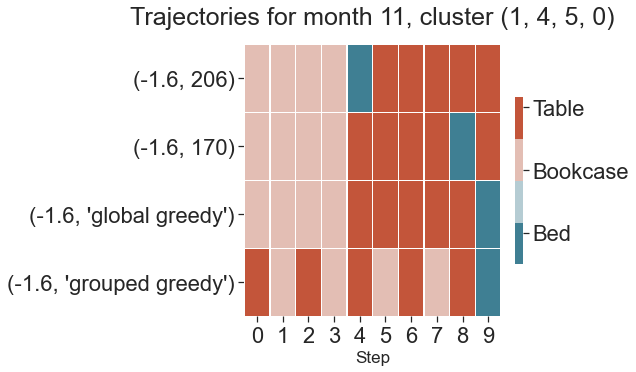

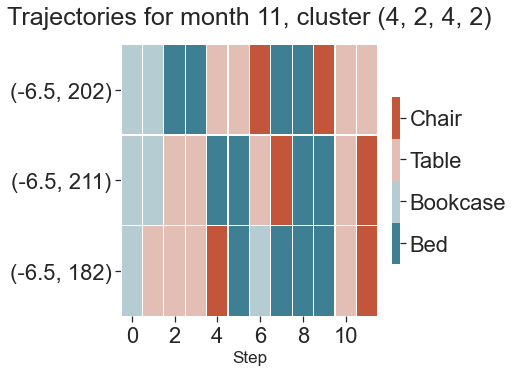

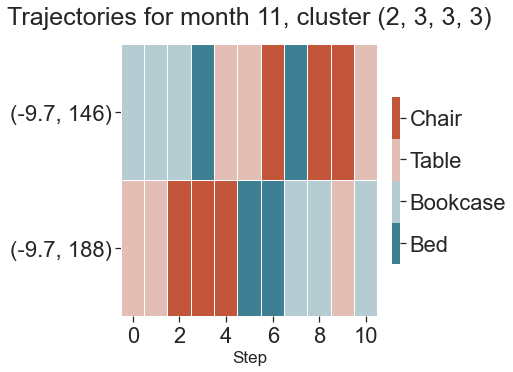

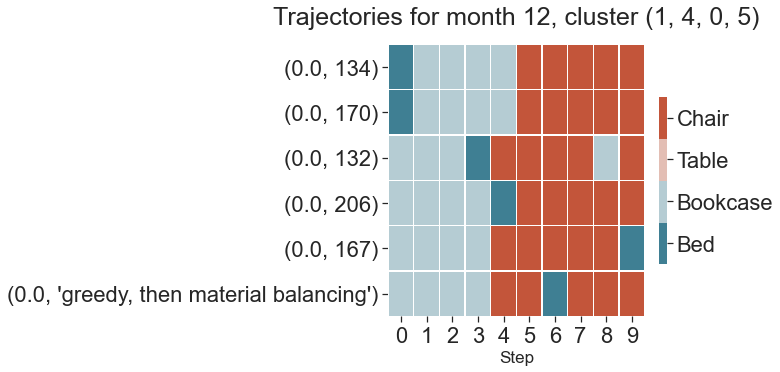

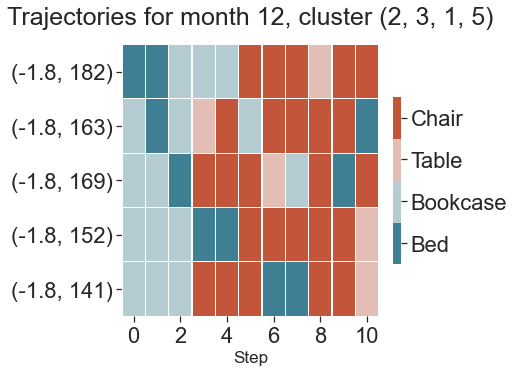

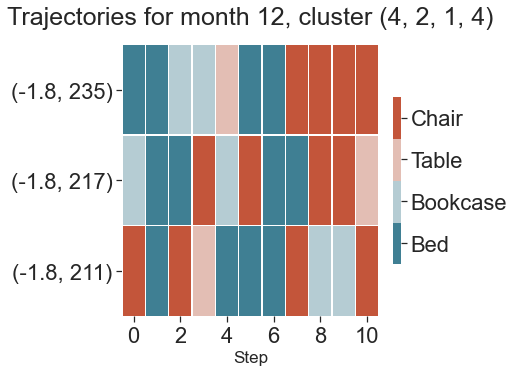

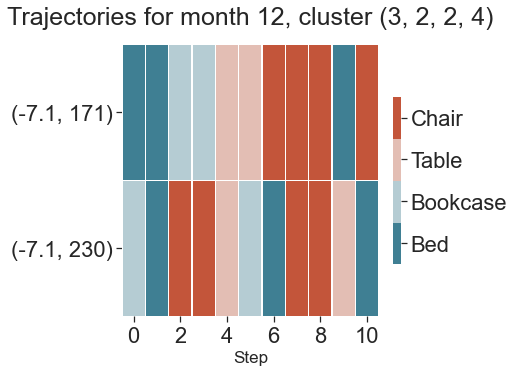

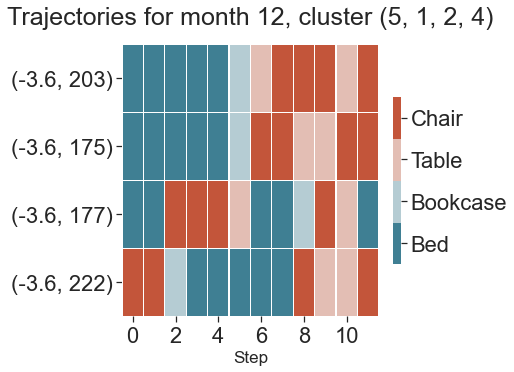

In [21]:
df_furn = get_furniture_dict(df_vp_sol, df_complete_sol)

df_profit, df_paths, df_leaves = generate_feasible_solutions(df_furn)

df_clusters = df_leaves.dropna()
df_clusters = df_clusters[df_clusters['Number of solutions']>= 2]

colormap = sns.diverging_palette(220, 20, n=4)

for m in df_clusters.month.unique():
    
    cluster = list(df_clusters[ (df_clusters.month == m)].solutions)
    df_solutions = furniture_list(df_built,vps,m)
    steps = df_solutions.columns
    df_solutions['difference'] = df_diff_with_mask[df_diff_with_mask.month == m].difference
    df_solutions['difference'] = df_solutions['difference'].round(1)
    for c in cluster:
        fig = plt.figure(figsize=(5, 5))
        idxs = df_furn[(df_furn['solutions'] == c) & (df_furn.month == m)].index
        df_plot = df_solutions[df_solutions.index.isin(idxs)]
        

        df_plot = df_plot[steps].sort_values(by=list(steps))
        df_plot = df_plot.dropna(axis = 1)
        strat_list = df_strat_paths.index[df_strat_paths[m] == c].tolist()
        for s in strat_list:
            items = strategy_dict[s][m-1]
            df_plot.loc[s] = [i+1 for i in items]
        y_axis_labels = list(zip(list(df_solutions[df_solutions.index == idxs[0]].difference)*len(df_plot.index), list(df_plot.index)))

        g= sns.heatmap(data = df_plot , 
                    cmap = colormap,
                    yticklabels=y_axis_labels,  cbar_kws = dict(use_gridspec=False,location="right", fraction = 0.03),
                    annot = False, linewidths=0.2)
        g.set_facecolor('xkcd:white')
        colorbar = g.collections[0].colorbar
        g.set_yticklabels(g.get_yticklabels(),rotation =0)

        #colorbar = fig.colorbar(g)
        r = 3
    
        colorbar.set_ticks([1 + 0.5 * r / (4) + r * i / (4) for i in range(4)])
        colorbar.set_ticklabels(['Bed', 'Bookcase', 'Table', 'Chair'])
        plt.title('Trajectories for month ' + str(m) + ', cluster ' + str(c), fontsize = 25, pad = 20)
        xlabel = plt.xlabel('Step', fontsize = 17)

In [22]:
strategy_dict[s][m-1]

[1, 1, 1, 1, 3, 3, 0, 3, 3, 3]

In [23]:
def plot_aggregated_decisions(month, vps, annot =False):
    sns.set(font_scale=1.5, style = 'ticks', palette = 'deep') 

    fig = plt.figure(figsize=(12, 4))
    #plt.title('Choices in trial ' + str(month) , fontsize = 25, pad = 20)

    df_solutions = furniture_list(df_built,vps,month)
    counts = df_solutions.apply(pd.value_counts).fillna(0)
    y_axis_labels = ['Bed', 'Bookcase', 'Table', 'Chair']
    subjs = list(counts.sum().astype(int))
    x_axis_labels = [str(counts.columns[i]+1) + '\n '+ str(round((subjs[i]/31),2)) + '' if subjs[i] <31 else str(counts.columns[i]+1)  for i in range(len(counts.columns))]
    #list(zip( list(counts.columns),list(counts.sum().astype(int)),))

    g= sns.heatmap(counts/31, cmap="OrRd",yticklabels = y_axis_labels,xticklabels = x_axis_labels,linewidths=0.2,
                   vmin=0, vmax=1, annot = annot)
    g.set_xticklabels(g.get_xticklabels(),rotation =0)
    fig.savefig('Images/aggregated_choices/agg_choice_month_' +str(month)+'.jpg',bbox_inches='tight')

#for m in range(1,13):    
#    plot_monthly_solution_traj_parts(m, vps)    
#plot_monthly_solution_traj_parts(m, vps)    

In [24]:
import math
env= gym.make('SmallFurniture-v0')
m = 1
init_res = env.reset(m-1)
#norm_cost = [env.costs[i] /init_res for i in range(4)]
#norm_profit = env.rewards_month[:,m-1]/sum(env.rewards_month[:,m-1])
data = np.vstack((env.costs, init_res)) 
items_possible = []
for f in range(4):
    res = []
    for r in range(6):
        if env.costs[f,r] >0:
            res.append(math.floor(init_res[r]/env.costs[f,r])*env.rewards_month[f,m-1])
        else:
            res.append(np.nan)
    items_possible.append(res)
        
m_poss = [min(items_possible[f]) for f in range(4)]
m_poss.append(np.nan)
profits = list(env.rewards_month[:,m-1])
profits.append(np.nan)
df_rank = pd.DataFrame(data,index = ['Bed', 'Bookcase', 'Table', 'Chair', 'Available'], columns = ['wood', 'metal', 'wsA', 'wsB', 'wsC', 'wsD'])
df_rank['profit'] = profits
df_rank['max_possible'] = m_poss
df_rank['max_possible']

Bed          24.0
Bookcase     28.0
Table        20.0
Chair        12.0
Available     NaN
Name: max_possible, dtype: float64

In [25]:
df_rank

,wood,metal,wsA,wsB,wsC,wsD,profit,max_possible
Bed,4.0,3.0,0.0,0.0,3.0,4.0,4.0,24.0
Bookcase,5.0,7.0,0.0,0.0,5.0,3.0,7.0,28.0
Table,2.0,5.0,4.0,6.0,0.0,0.0,4.0,20.0
Chair,4.0,1.0,4.0,1.0,0.0,0.0,2.0,12.0
Available,52.0,49.0,26.0,30.0,23.0,26.0,NaN,NaN


In [26]:
print(df_rank[['profit', 'max_possible']].to_latex())

\begin{tabular}{lrr}
\toprule
{} &  profit &  max\_possible \\
\midrule
Bed       &     4.0 &          24.0 \\
Bookcase  &     7.0 &          28.0 \\
Table     &     4.0 &          20.0 \\
Chair     &     2.0 &          12.0 \\
Available &     NaN &           NaN \\
\bottomrule
\end{tabular}



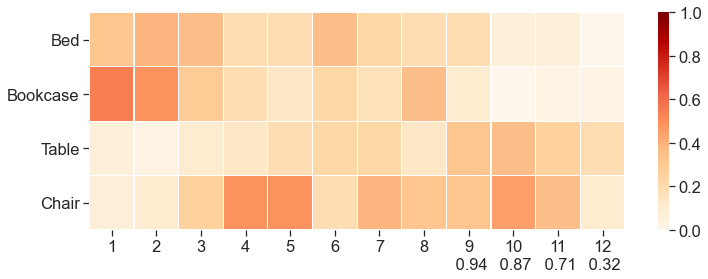

In [27]:
plot_aggregated_decisions(8, vps, annot=False)     

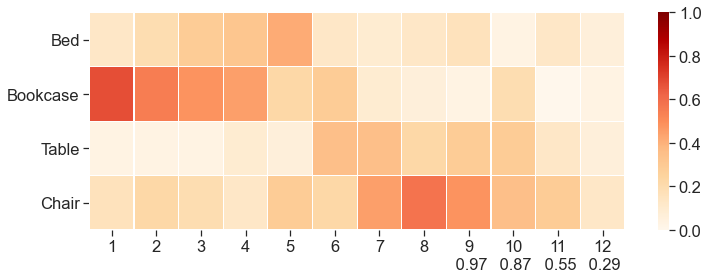

In [28]:
plot_aggregated_decisions(10, vps, annot=False)     